# Continous Observation Space
## Part 1:  Q-learning with Binarized state spaces

This notebook will guide you through implementation of vanilla Q-learning algorithm... not again! just kidding this will be given.
You will get `QlearningAgent` class and `play_and_train` fundtion. see below

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random, math
import numpy as np
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on http://inst.eecs.berkeley.edu/~cs188/sp09/pacman.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        #<YOUR CODE HERE>
        value = max(self.get_qvalue(state,action) for action in possible_actions)
        
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        #<YOUR CODE HERE>
        value = (1-learning_rate) * self.get_qvalue(state,action) + learning_rate * (reward + gamma * self.get_value(next_state))
        
        self.set_qvalue(state, action, value)

    
    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #<YOUR CODE HERE>
        best_acton = None
        best_q = float("-inf")
        for action in possible_actions:
            cur_q = self.get_qvalue(state,action)
            if cur_q > best_q:
                best_q = cur_q
                best_action  = action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).
        
        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = random.choice(possible_actions)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon

        #<YOUR CODE HERE>
        if random.random() > epsilon:
            chosen_action = self.get_best_action(state)
        else:
            chosen_action = action
        
        return chosen_action

In [0]:
def play_and_train(env,agent,t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)#<YOUR CODE>
        
        next_s, r, done, _ = env.step(a)
        
        # train (update) agent for state s
        #<YOUR CODE HERE>
        agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward
    
        
    

In [2]:
# fix no screen problem in collab (https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab?rq=1)
!apt-get install -y xvfb python-opengl
!pip install gym pyvirtualdisplay 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [0]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [4]:

display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

## Cartpole
Use agent to train efficiently on ***CartPole-v0***.

This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

let's first have a look at the environment...

first state:[-0.01336203  0.00592878 -0.0072919   0.03372623]


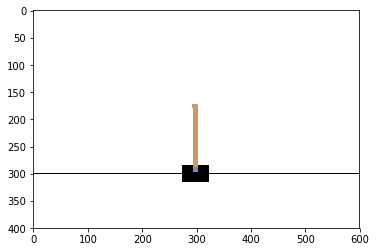

In [0]:


env = gym.make("CartPole-v0")
n_actions = env.action_space.n
env.reset()
print("first state:%s" % (env.reset()))
m = env.render(mode='rgb_array')
plt.imshow(m)

now let's look at the environment documentation to understand what does the state 4-tuple mean:

In [0]:
print(env.unwrapped.__doc__)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson

    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24°           24°
        3	Pole Velocity At Tip      -Inf            Inf
        
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
        Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity o

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

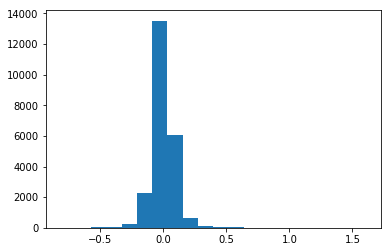

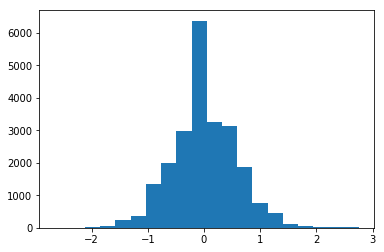

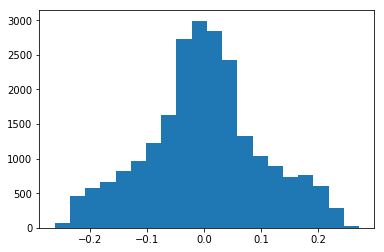

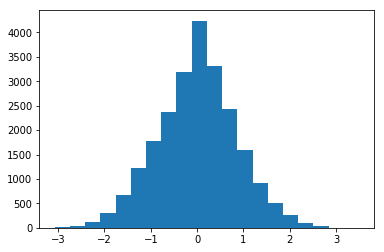

In [0]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Binarize environment

In [0]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper): # notice the usage of wrapper
    
    def _observation(self, state):    
        
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension
        
        #state = <YOUR CODE> # n_digits can be any integer but we recommend between 0 and 2 and can (should) be different between state dimension>
        digits = [0, 1, 2, 1]

        state = [round(x, digits[index]) for index,  x in enumerate(state)]
      
        return tuple(state)

In [0]:
env = Binarizer(gym.make("CartPole-v0"))

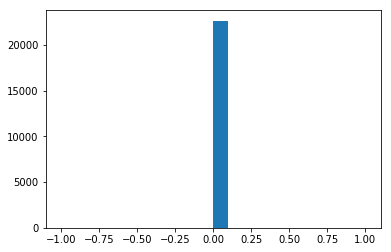

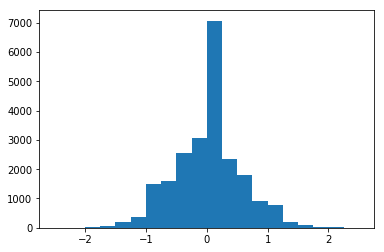

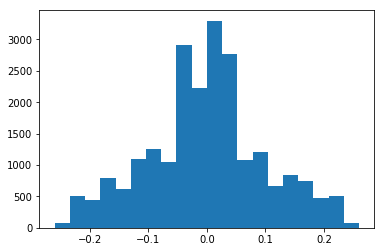

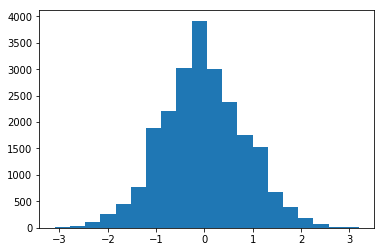

In [0]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done: break
            
all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__ 
* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization. 
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (`len(QLearningAgent._qvalues)`), but not required.
* Feel free to change what ever you want (eps # steps etc)


In [0]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions= lambda s: range(n_actions))

eps = 0.055362946809715236 mean reward = 67.8 i= 2980


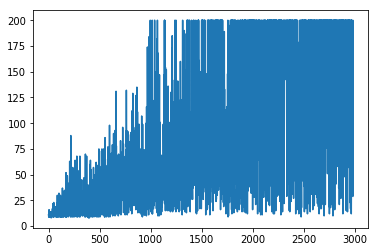

In [0]:
from IPython.display import clear_output
rewards = []
for i in range(3000):
    rewards.append(play_and_train(env,agent))   
    
    #OPTIONAL YOUR CODE: adjust epsilon
    
    if i %20 ==0:
        agent.epsilon *= 0.99
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]) , 'i=', i)
        plt.plot(rewards)
        plt.show()
        

### Check Solution

In [0]:
assert np.mean(rewards[:-100])>70 # good enough
print('good enough')

good enough


## Part 2:  Q-learning with Function Approximation

Consider asking colab for a gpu enabled kernel

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# fix no screen problem in collab (https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab?rq=1)
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


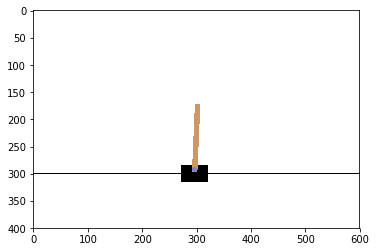

In [7]:
#make sure we got everything in place

display = Display(visible=0, size=(400, 300))
display.start()
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

### Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (L.Dense) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doingbackprop".

In [0]:
import gym
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple  

In [0]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
number_of_states = state_dim[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
MEMROY_SIZE = 2000
BATCH_SIZE = 32
gamma = 0.99

In [11]:
n_actions,state_dim

(2, (4,))

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, ouput_size):
        super(Net, self).__init__()
        self.pipe = nn.Sequential(nn.Linear(input_size, 50), nn.ReLU(),
                                  nn.Linear(50, ouput_size))

    def forward(self, x):
        return self.pipe(x)
    
    def _init_weights(self, m):
        if type(m) == nn.Linear:
            m.weight.data.normal_(0, 0.1)
            
    def initWeights(self):
        self.pipe.apply(self._init_weights)


In [0]:
policy_net  = Net(number_of_states, n_actions).to(device)
policy_net.initWeights()

In [14]:
target_net  = Net(number_of_states, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

Net(
  (pipe): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [0]:
loss_func = nn.MSELoss()
NUMBER_OF_EPISODES = 220
lr = 1e-2

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)

In [0]:
class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [None for _ in range(self.capacity)]
        self.position = 0
        self.memory_counter = 0

    def push(self, *args):

        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        self.memory_counter  += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


In [0]:
def select_action(state, epsilon = 0):

    state = torch.unsqueeze(torch.FloatTensor(state), 0).to(device)

    if random.random() <= epsilon:
        with torch.no_grad():
            selected_action = np.random.randint(0, n_actions)

    else:

        actions_expected_rewards = policy_net(state)
        selected_action = torch.max(actions_expected_rewards, 1)[1].cpu().data.numpy()[0].item()

    return selected_action

In [0]:
def train():
    batch_sample = replay_memory.sample(batch_size=BATCH_SIZE)
    b_s = torch.FloatTensor([sample.state for sample in batch_sample]).to(device)

    b_a = torch.LongTensor([sample.action for sample in batch_sample]).reshape(-1,1).to(device)
    b_r = torch.FloatTensor([sample.reward for sample in batch_sample]).reshape(-1,1).to(device)
    b_s_ = torch.FloatTensor([sample.next_state for sample in batch_sample]).to(device)

    q_eval = policy_net(b_s).gather(1, b_a)  # shape (batch, 1)
    q_next = target_net(b_s_).detach()  # detach from graph, don't backpropagate
    q_target = b_r + gamma * q_next.max(1)[0].view(BATCH_SIZE, 1)  # shape (batch, 1)
    loss = loss_func(q_eval, q_target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [0]:
num_of_episodes_for_update = 100
replay_memory = ReplayMemory(MEMROY_SIZE)
stated_trainning = False
cycles = 0
for episode in range(NUMBER_OF_EPISODES):
    
    state = env.reset()
    reward = 0

    episode_tato_reward = 0

    while True:

        if cycles % num_of_episodes_for_update == 0:
            #print('copy weights')

            target_net.load_state_dict(policy_net.state_dict())

        cycles += 1

        env.render()

        action = select_action(state, epsilon=0.1)

        next_state, reward, done, _ = env.step(action)

        x, x_dot, theta, theta_dot = next_state
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        reward = r1 + r2


        episode_tato_reward += reward

        replay_memory.push(state, action, next_state, reward)

        if replay_memory.memory_counter >= MEMROY_SIZE:

            if not stated_trainning:
                stated_trainning = True
                print('start trainning')

            train()

        state = next_state

        if done:
            episode_tato_reward +=-1

            if stated_trainning:
                #print(episode_tato_reward)
                print('Ep:  {0} | Ep_r:  {1}'.format(episode, episode_tato_reward))
            else:
                if episode % 100 == 0:
                    print(episode_tato_reward)

            break


0.10137451389336283
start trainning
Ep:  46 | Ep_r:  1.513796832087574
Ep:  47 | Ep_r:  1.234364152815676
Ep:  48 | Ep_r:  3.040617229486963
Ep:  49 | Ep_r:  9.0593140471422
Ep:  50 | Ep_r:  9.810071663408099
Ep:  51 | Ep_r:  14.683738607827788
Ep:  52 | Ep_r:  3.9038004481775728
Ep:  53 | Ep_r:  6.037512655120256
Ep:  54 | Ep_r:  5.327255038621645
Ep:  55 | Ep_r:  -1.7080571493764731
Ep:  56 | Ep_r:  11.118124600511242
Ep:  57 | Ep_r:  1.5490213556958858
Ep:  58 | Ep_r:  1.6082574979125592
Ep:  59 | Ep_r:  -1.3864030514296526
Ep:  60 | Ep_r:  1.2898790127953434
Ep:  61 | Ep_r:  4.083050076625835
Ep:  62 | Ep_r:  1.4712057566908232
Ep:  63 | Ep_r:  2.1501984801900935
Ep:  64 | Ep_r:  3.1016751843244235
Ep:  65 | Ep_r:  1.1114137665920891
Ep:  66 | Ep_r:  3.005520455959587
Ep:  67 | Ep_r:  0.3074633014334034
Ep:  68 | Ep_r:  1.7571286915507573
Ep:  69 | Ep_r:  0.595249895475134
Ep:  70 | Ep_r:  -0.356373693658368
Ep:  71 | Ep_r:  1.5167534348048028
Ep:  72 | Ep_r:  0.4222444694327945
Ep

Instructions for updating:
Use tf.cast instead.


good job


![alt text](https://cdn-images-1.medium.com/max/1600/1*LqQEd7iO2ECwEzW2vG0OBw.png)

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

In [33]:
!pip install JSAnimation
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))


  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


In [1]:
#record agent
frames = []
s = env.reset()
epsilon = 0
total_reward = 0
for t in range(1000):
    frames.append(env.render(mode = 'rgb_array'))
    a = get_action(s, epsilon=epsilon)       
    next_s, r, done, _ = env.step(a)
    total_reward += r
    s = next_s
    if done: break
print(t)
env.close()
display_frames_as_gif(frames)

NameError: ignored

In [0]:
# record sessions - didn't work for me in colab
# import gym.wrappers
# env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True, write_upon_reset=True)
# sessions = [generate_session(epsilon=0, train=False) for _ in range(1)]
# print(np.mean(sessions))
# env.close()
# sessions
#show video
# from IPython.display import HTML
# import os

# video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

# HTML("""
# <video width="640" height="480" controls>
#   <source src="{}" type="video/mp4">
# </video>
# """.format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices